# Universe Machine mass functions

* SMF of the new UM when considering in-situ, ex-situ, and the sum of both compared to Songs SMF
* look at the scatter in M* and Mhalo
- for in-situ
- for in-situ + ex-situ
- for N most massive galaxies

TODO:
* finalize setup code (see song's comments)
* work out why we don't see much reduction in scatter
* plot SMF using song's helpers (https://redwoodforest.slack.com/files/U5WQ5K6BV/F8D28UNQY/simple_functions_to_estimate_stellar_mass_function.py)
    * Talk to song about potential bug in calculating errors here
    * question about https://github.com/dr-guangtou/hsc_um2/blob/master/hsc_um2/stellar_mass_function.py#L44-L50. We are computing the error on the normalized smf and then normalizing the error again. I think this would be right if the SMF norm step came after this if block? We should compute Poisson errors on the unscaled SMF counts?
* Add labels to plotly figures

## Install and load data

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt

import plotly.offline as py
from plotly.offline import download_plotlyjs, init_notebook_mode
init_notebook_mode(connected=True)
import plotly.graph_objs as go

# Local libs
import plots
import cluster_sum
import stellar_mass_function as smf
from importlib import reload # for when I mess up local libs

In [2]:
datadir = os.getenv("dataDir") + "/universe_machine/"
catalog_file = "sfr_catalog_insitu_exsitu_0.712400_final.npz"

catalog = np.load(datadir + catalog_file)
centrals = catalog["centrals"]
satellites = catalog["satellites"]

# Our data

Let's get a very broad sense of our data

In [4]:
print(centrals.dtype)
print(len(centrals))
print(len(satellites))
print(satellites[:10])

[('id', '<i8'), ('upid', '<i8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('m', '<f8'), ('mp', '<f8'), ('sm', '<f8'), ('icl', '<f8'), ('sfr', '<f8')]
385125
10809469
[ (8272347655, 8272347654,  13.83487,  18.749399,  16.14661 ,   1.98400000e+09,   3.11700000e+09,   2.31400000e+05,   0.00000000e+00,   6.41000000e-05)
 (8272348262, 8272347732,  15.026  ,  17.7521  ,  17.388531,   1.98400000e+09,   2.26700000e+09,   1.15200000e+03,   0.00000000e+00,   2.51000000e-06)
 (8272348449, 8272347732,  15.09965,  17.864719,  17.39245 ,   4.10900000e+09,   9.77600000e+09,   3.21900000e+05,   0.00000000e+00,   1.55000000e-04)
 (8272347739, 8272347732,  15.12861,  17.99032 ,  17.20083 ,   2.40900000e+09,   4.67600000e+09,   5.25000000e+05,   0.00000000e+00,   9.07200000e-05)
 (8272346869, 8272347732,  14.98359,  18.042549,  17.36433 ,   2.97500000e+09,   5.24200000e+09,   2.55700000e+06,   0.00000000e+00,   3.47100000e-04)
 (8272361474, 8272347732,  15.10398,  17.784781,  17.37109 ,   1.21800000e+10

385117 centrals without ICL of our 385125 samples


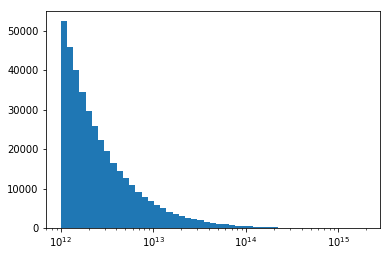

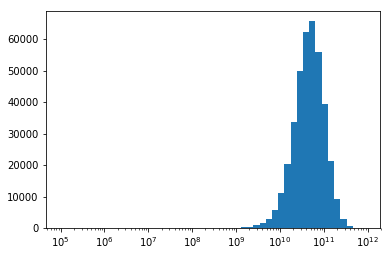

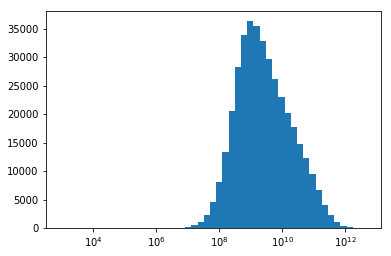

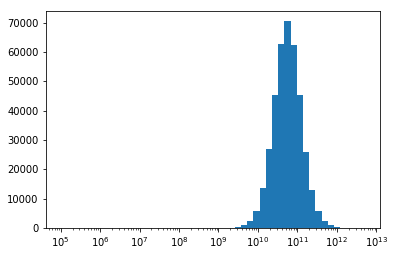

In [5]:
fig, ax = plt.subplots()
_ = ax.hist(centrals["mp"], bins = np.geomspace(np.amin(centrals["mp"]), np.amax(centrals["mp"]), 50))
_ = ax.set(xscale="log")

fig, ax = plt.subplots()
_ = ax.hist(centrals["sm"], bins = np.geomspace(np.amin(centrals["sm"]), np.amax(centrals["sm"]), 50))
_ = ax.set(xscale="log")

fcentrals = centrals[np.nonzero(centrals["icl"])[0]]
fig, ax = plt.subplots()
_ = ax.hist(fcentrals["icl"], bins = np.geomspace(np.amin(fcentrals["icl"]), np.amax(fcentrals["icl"]), 50))
_ = ax.set(xscale="log")
print(
    "{} centrals without ICL of our {} samples".format(len(np.nonzero(centrals["icl"])[0]), len(centrals))
)

fig, ax = plt.subplots()
_ = ax.hist(
    centrals["icl"] + centrals["sm"],
    bins = np.geomspace(
        np.amin(centrals["icl"]) + np.amin(centrals["sm"]),
        np.amax(centrals["icl"]) + np.amax(centrals["sm"]),
        50))
_ = ax.set(xscale="log")

# SMHM relations

Now let's plot the SM, halo mass relations for centrals

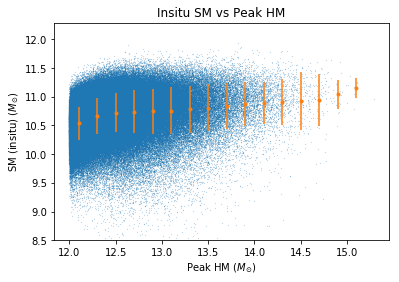

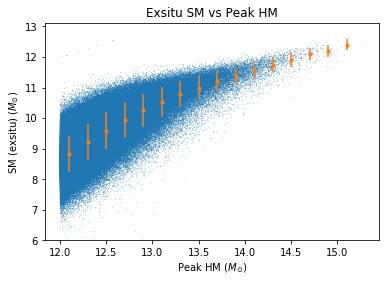

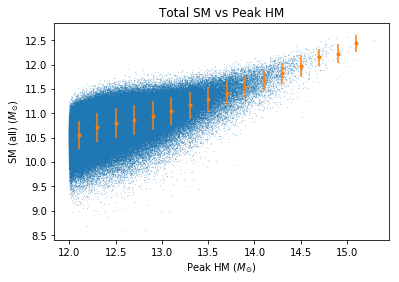

In [43]:
reload(plots)
ax = plots.dm_vs_insitu(centrals)
ax.set(ylim=8.5) # ignore crazy small galaxies

ax = plots.dm_vs_exsitu(centrals)
ax.set(ylim=6) # not sure why by default it ignores a bunch of data

plots.dm_vs_all_sm(centrals)

# SMHM for cluster

What happens if we start to plot this relation for multiple members of the cluster?

In [13]:
reload(cluster_sum)
data = np.array(
    [centrals] + 
    [cluster_sum.centrals_with_satellites(centrals, satellites, i) for i in range(1, 10)]
)

In [14]:
allSats = cluster_sum.centrals_with_satellites(centrals, satellites, 0.999)

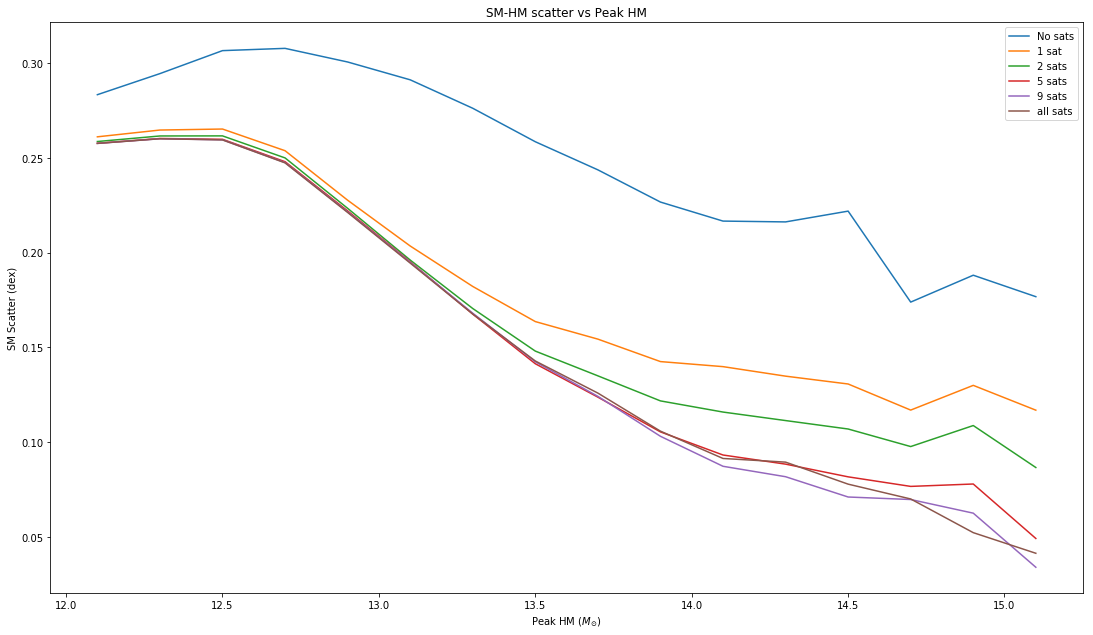

In [41]:
reload(plots)
plots.dm_vs_all_sm_error([data[0], data[1], data[2], data[5], data[9], allSats], 
                           labels = ["No sats", "1 sat", "2 sats", "5 sats", "9 sats", "all sats"])
# You can't really see this in the scatter plots though. Errors are too small compared to range of plot

# Plotly

Let's see if we can make some interactive plots that illustrate this better

# SMF

What does our SMF look like?

[  8.80161096   9.20713809   9.61266523  10.01819237  10.42371951
  10.82924664  11.23477378  11.64030092  12.04582805  12.45135519] [  7.39777865e-02   7.95261205e-01   1.35194405e+01   1.45434164e+02
   6.97931098e+02   1.03200862e+03   4.17431990e+02   6.09453665e+01
   5.70245438e+00   3.82218564e-01] [ 0.00167676  0.00549762  0.02266728  0.07434526  0.16286447  0.19804403
  0.12595429  0.04812718  0.01472146  0.00381132]
[  9.32606211   9.751092    10.17612189  10.60115178  11.02618167
  11.45121157  11.87624146  12.30127135  12.72630124  13.15133113] [  5.64666168e-01   1.26696971e+01   1.99897705e+02   8.64733298e+02
   8.30953321e+02   2.77439310e+02   6.38249227e+01   1.31637800e+01
   1.88810250e+00   1.47048481e-01] [ 0.00441994  0.02093648  0.08316191  0.17296635  0.16955432  0.09797258
  0.04699111  0.02134081  0.00808227  0.00225554]


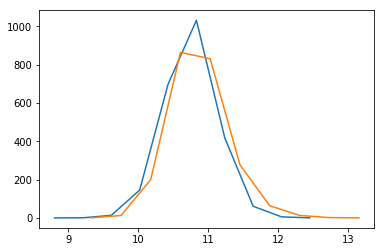

In [45]:
reload(smf)
fig, ax = plt.subplots()
for stellar_masses in [
    np.log10(data[0]["sm"] + data[0]["icl"]), np.log10(allSats["sm"] + allSats["icl"])
]:
    sim_volume = 400 # https://redwoodforest.slack.com/archives/C5W6EQCAU/p1513187949000425 SMDPL
    x, y, err = smf.compute_smf(
        stellar_masses, sim_volume, 10, 
        np.min(stellar_masses), np.max(stellar_masses),
    )
    print(x, y, err)
    ax.errorbar(x, y, yerr = err)